# Correlation to nuclear segmentation

The `nuclear_correlation` module provides metrics to assess how well cell segmentation masks align with nuclear segmentation masks. It is applicable only when nuclear masks are available.

In [1]:
%load_ext autoreload
%autoreload 2


import spatialdata as sd

sdata = sd.read_zarr("/g/huber/projects/CODEX/segtraq/data/xenium_sp_subset.zarr")

/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
version mismatch: detected: RasterFormatV02, requested: FormatV04
/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 're

The `spatialdata`dataset contains cell and nuclear masks as `Shapes`and `Labels`, as shown below.

In [7]:
sdata

SpatialData object, with associated Zarr store: /g/huber/projects/CODEX/segtraq/data/xenium_sp_subset.zarr
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 448, 527), (3, 224, 264), (3, 112, 131), (3, 56, 66), (3, 28, 33)
│     ├── 'if_image': DataTree[cyx] (3, 221, 260), (3, 111, 130), (3, 55, 65), (3, 28, 33), (3, 13, 16)
│     ├── 'morphology_focus': DataTree[cyx] (1, 763, 899), (1, 381, 450), (1, 191, 225), (1, 95, 112), (1, 47, 56)
│     └── 'morphology_mip': DataTree[cyx] (1, 763, 899), (1, 381, 450), (1, 191, 225), (1, 95, 112), (1, 47, 56)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (763, 899), (381, 450), (191, 225), (95, 112), (47, 56)
│     └── 'nucleus_labels': DataTree[yx] (763, 899), (381, 450), (191, 225), (95, 112), (47, 56)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 8) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (158, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (122, 2) (2D shapes)
│     └──

In [8]:
sdata["table"]

AnnData object with n_obs × n_vars = 122 × 313
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

## Intersection over Union between cell and nucleus masks

First, we compute the Intersection over Union (IoU) between cell and nuclear masks using `compute_cell_nuc_ious`.

In [9]:
import time

import segtraq as st

n = 1

start = time.time()
results_df = st.nc.compute_cell_nuc_ious(sdata, n_jobs=n)
end = time.time()

print(f"Elapsed time with {n} threads: {end - start:.2f} seconds")

Processing IoU between cells and nuclei: 100%|██████████| 158/158 [00:00<00:00, 970.59it/s] 

Elapsed time with 1 threads: 0.17 seconds


For each `cell_id`, we obtain the ID (`best_nuc_id`) of the nucleus mask with the highest `IoU`. If a cell does not overlap with any nucleus, the function returns a missing value for `best_nuc_id`. If the nucleus has an invalid geometry, `IoU`is reported as `NA`.

In [10]:
results_df

,cell_id,best_nuc_id,IoU
0,4613,4613.0,0.094093
1,4614,4614.0,0.207238
2,4615,4615.0,0.178686
3,4616,4616.0,0.292909
4,4617,4617.0,0.161824
...,...,...,...
153,80765,NaN,0.000000
154,80766,NaN,0.000000
155,80767,NaN,0.000000
156,80768,NaN,0.000000


We will store the results in the `.obs` of the `Table` within the `sdata` object for plotting.

In [11]:
ious_df = results_df.set_index("cell_id")

sdata["table"].obs["IoU"] = sdata["table"].obs["cell_id"].map(ious_df["IoU"])
sdata["table"].obs["best_nuc_id"] = sdata["table"].obs["cell_id"].map(ious_df["best_nuc_id"])

/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/spatialdata/_core/spatialdata.py:511: UserWarning: Converting `region_key: region` to categorical dtype.
  convert_region_column_to_categorical(table)
/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `cell_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `cell_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/pytho

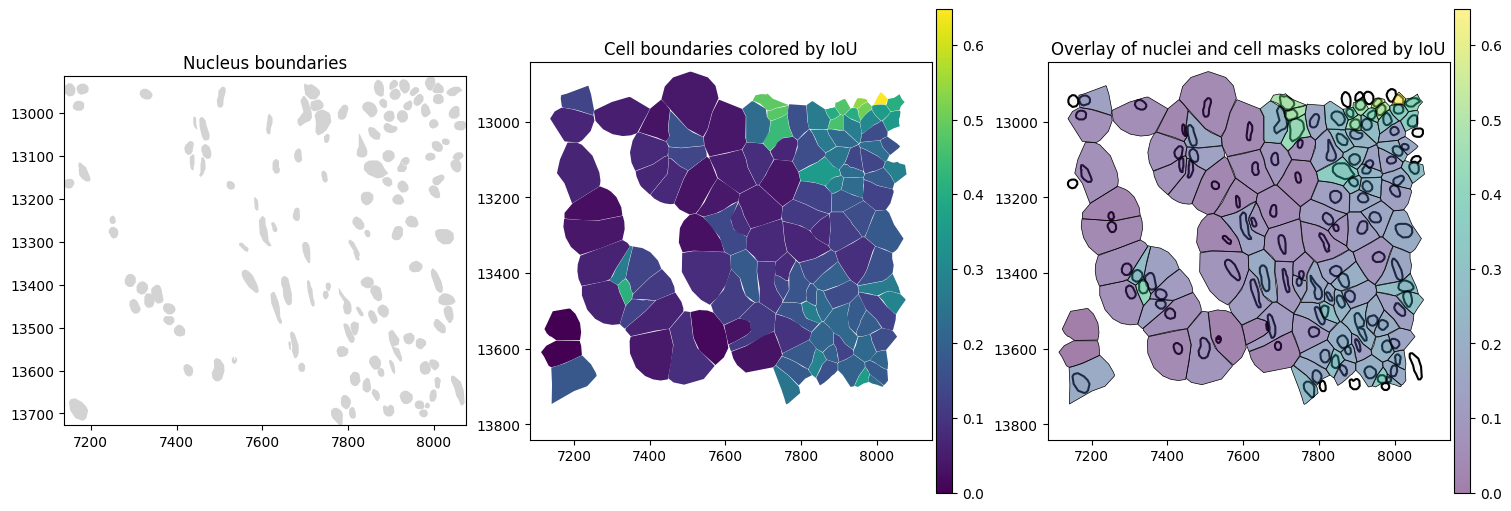

In [20]:
import matplotlib.pyplot as plt

axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)[1].flatten()

# link annotations with cell boundaries
sdata.tables["table"].obs["region"] = "cell_boundaries"
sdata.set_table_annotates_spatialelement("table", region="cell_boundaries")

# plot
sdata.pl.render_shapes("nucleus_boundaries").pl.show(
    ax=axes[0], title="Nucleus boundaries", coordinate_systems="global"
)

sdata.pl.render_shapes("cell_boundaries", color="IoU").pl.show(
    ax=axes[1], title="Cell boundaries colored by IoU", coordinate_systems="global"
)

sdata.pl.render_shapes(
    element="nucleus_boundaries",
    fill_alpha=0.2,
    outline_alpha=1.0,
    outline_color="black",
).pl.render_shapes(
    element="cell_boundaries",
    color="IoU",
    cmap="viridis",
    fill_alpha=0.5,
    outline_alpha=1.0,
    outline_width=0.5,
    outline_color="black",
).pl.show(ax=axes[2], title="Overlay of nuclei and cell masks colored by IoU", colorbar=True)

In the plots above, we can see that cells that have a high overlap with nuclei, also show a high IoU value. Below, we plot a histogram of IoU values and can see that the median IoU is at 0.16, i.e. 16% overlap. 

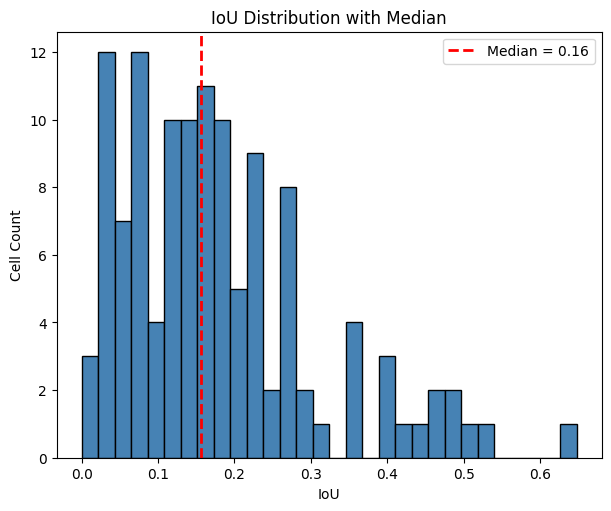

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare IoU values
ious = sdata["table"].obs["IoU"].dropna()
median_iou = np.median(ious)

# Set up figure with histogram
fig, ax = plt.subplots(figsize=(6, 5), constrained_layout=True)

# Plot histogram
ax.hist(ious, bins=30, color="steelblue", edgecolor="black")

# Add median line
ax.axvline(
    median_iou,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Median = {median_iou:.2f}",
)

# Decorate
ax.set_title("IoU Distribution with Median")
ax.set_xlabel("IoU")
ax.set_ylabel("Cell Count")
ax.legend()

plt.show()